In [5]:
import json
from urllib import parse
import pandas as pd
import sqlite3
import numpy as np
from matplotlib import colors, cm, pyplot as plt
import urllib.request
from PIL import Image

In [6]:
PIXELS_X = 910
PIXELS_Y = 910  # equal to the number of scan lines
MZ_MIN = 100.0
MZ_MAX = 1700.0
SCAN_MAX = PIXELS_Y
SCAN_MIN = 1
MZ_PER_TILE = 18.0
TILES_PER_FRAME = int((MZ_MAX - MZ_MIN) / MZ_PER_TILE) + 1
MIN_TILE_IDX = 0
MAX_TILE_IDX = TILES_PER_FRAME-1

In [7]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [8]:
MZ_PER_PIXEL_X = MZ_PER_TILE / PIXELS_X
MZ_PER_PIXEL_X

0.01978021978021978

In [10]:
# specify the precursor cuboid to visualise
RUN_NAME = '190719_Hela_Ecoli_1to1_01'
PRECURSOR_ID = 22624
PRECURSOR_CUBOID_ZIP_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/precursor-cuboids/{}'.format(RUN_NAME)
PRECURSOR_CUBOID_ZIP_FILE_NAME = '{}/exp-dwm-test-run-{}-precursor-{}.zip'.format(PRECURSOR_CUBOID_ZIP_DIR, RUN_NAME, PRECURSOR_ID)
PRECURSOR_CUBOID_EXTRACT_DIR = '{}/exp-dwm-test-run-{}-precursor-{}-extracted'.format(PRECURSOR_CUBOID_ZIP_DIR, RUN_NAME, PRECURSOR_ID)
PRECURSOR_CUBOID_MS1_PKL = '{}/exp-dwm-test-run-{}-precursor-{}-cuboid-points-ms1-df.pkl'.format(PRECURSOR_CUBOID_EXTRACT_DIR, RUN_NAME, PRECURSOR_ID)

from zipfile import ZipFile
zf = ZipFile(PRECURSOR_CUBOID_ZIP_FILE_NAME, 'r')
zf.extractall(PRECURSOR_CUBOID_EXTRACT_DIR)
zf.close()

In [11]:
# load the raw points for the precursor
raw_df = pd.read_pickle(PRECURSOR_CUBOID_MS1_PKL)

In [24]:
mz_lower = raw_df.mz.min()
mz_upper = raw_df.mz.max()
scan_lower = raw_df.scan.min()
scan_upper = raw_df.scan.max()

In [25]:
raw_df.columns

Index(['frame_id', 'frame_type', 'mz', 'scan', 'intensity',
       'retention_time_secs'],
      dtype='object')

In [26]:
colour_map = plt.get_cmap('rainbow')
norm = colors.LogNorm(vmin=1, vmax=1000, clip=True)  # aiming to get good colour variation in the lower range, and clipping everything else

In [27]:
# calculate the colour to represent the intensity
colours_l = []
for i in raw_df.intensity.unique():
    colours_l.append((i, colour_map(norm(i), bytes=False)[:3]))
colours_df = pd.DataFrame(colours_l, columns=['intensity','colour'])
raw_colour_df = pd.merge(raw_df, colours_df, how='left', left_on=['intensity'], right_on=['intensity'])

In [28]:
frames_l = []
for group_name,group_df in raw_colour_df.groupby(['frame_id'], as_index=False):
    frames_l.append(group_df)

In [29]:
len(frames_l)

28

In [30]:
columns = 2
rows = int(len(frames_l) / columns)

In [31]:
rows

14

In [32]:
if len(frames_l) % columns != 0:
    rows += 1

In [33]:
rows

14

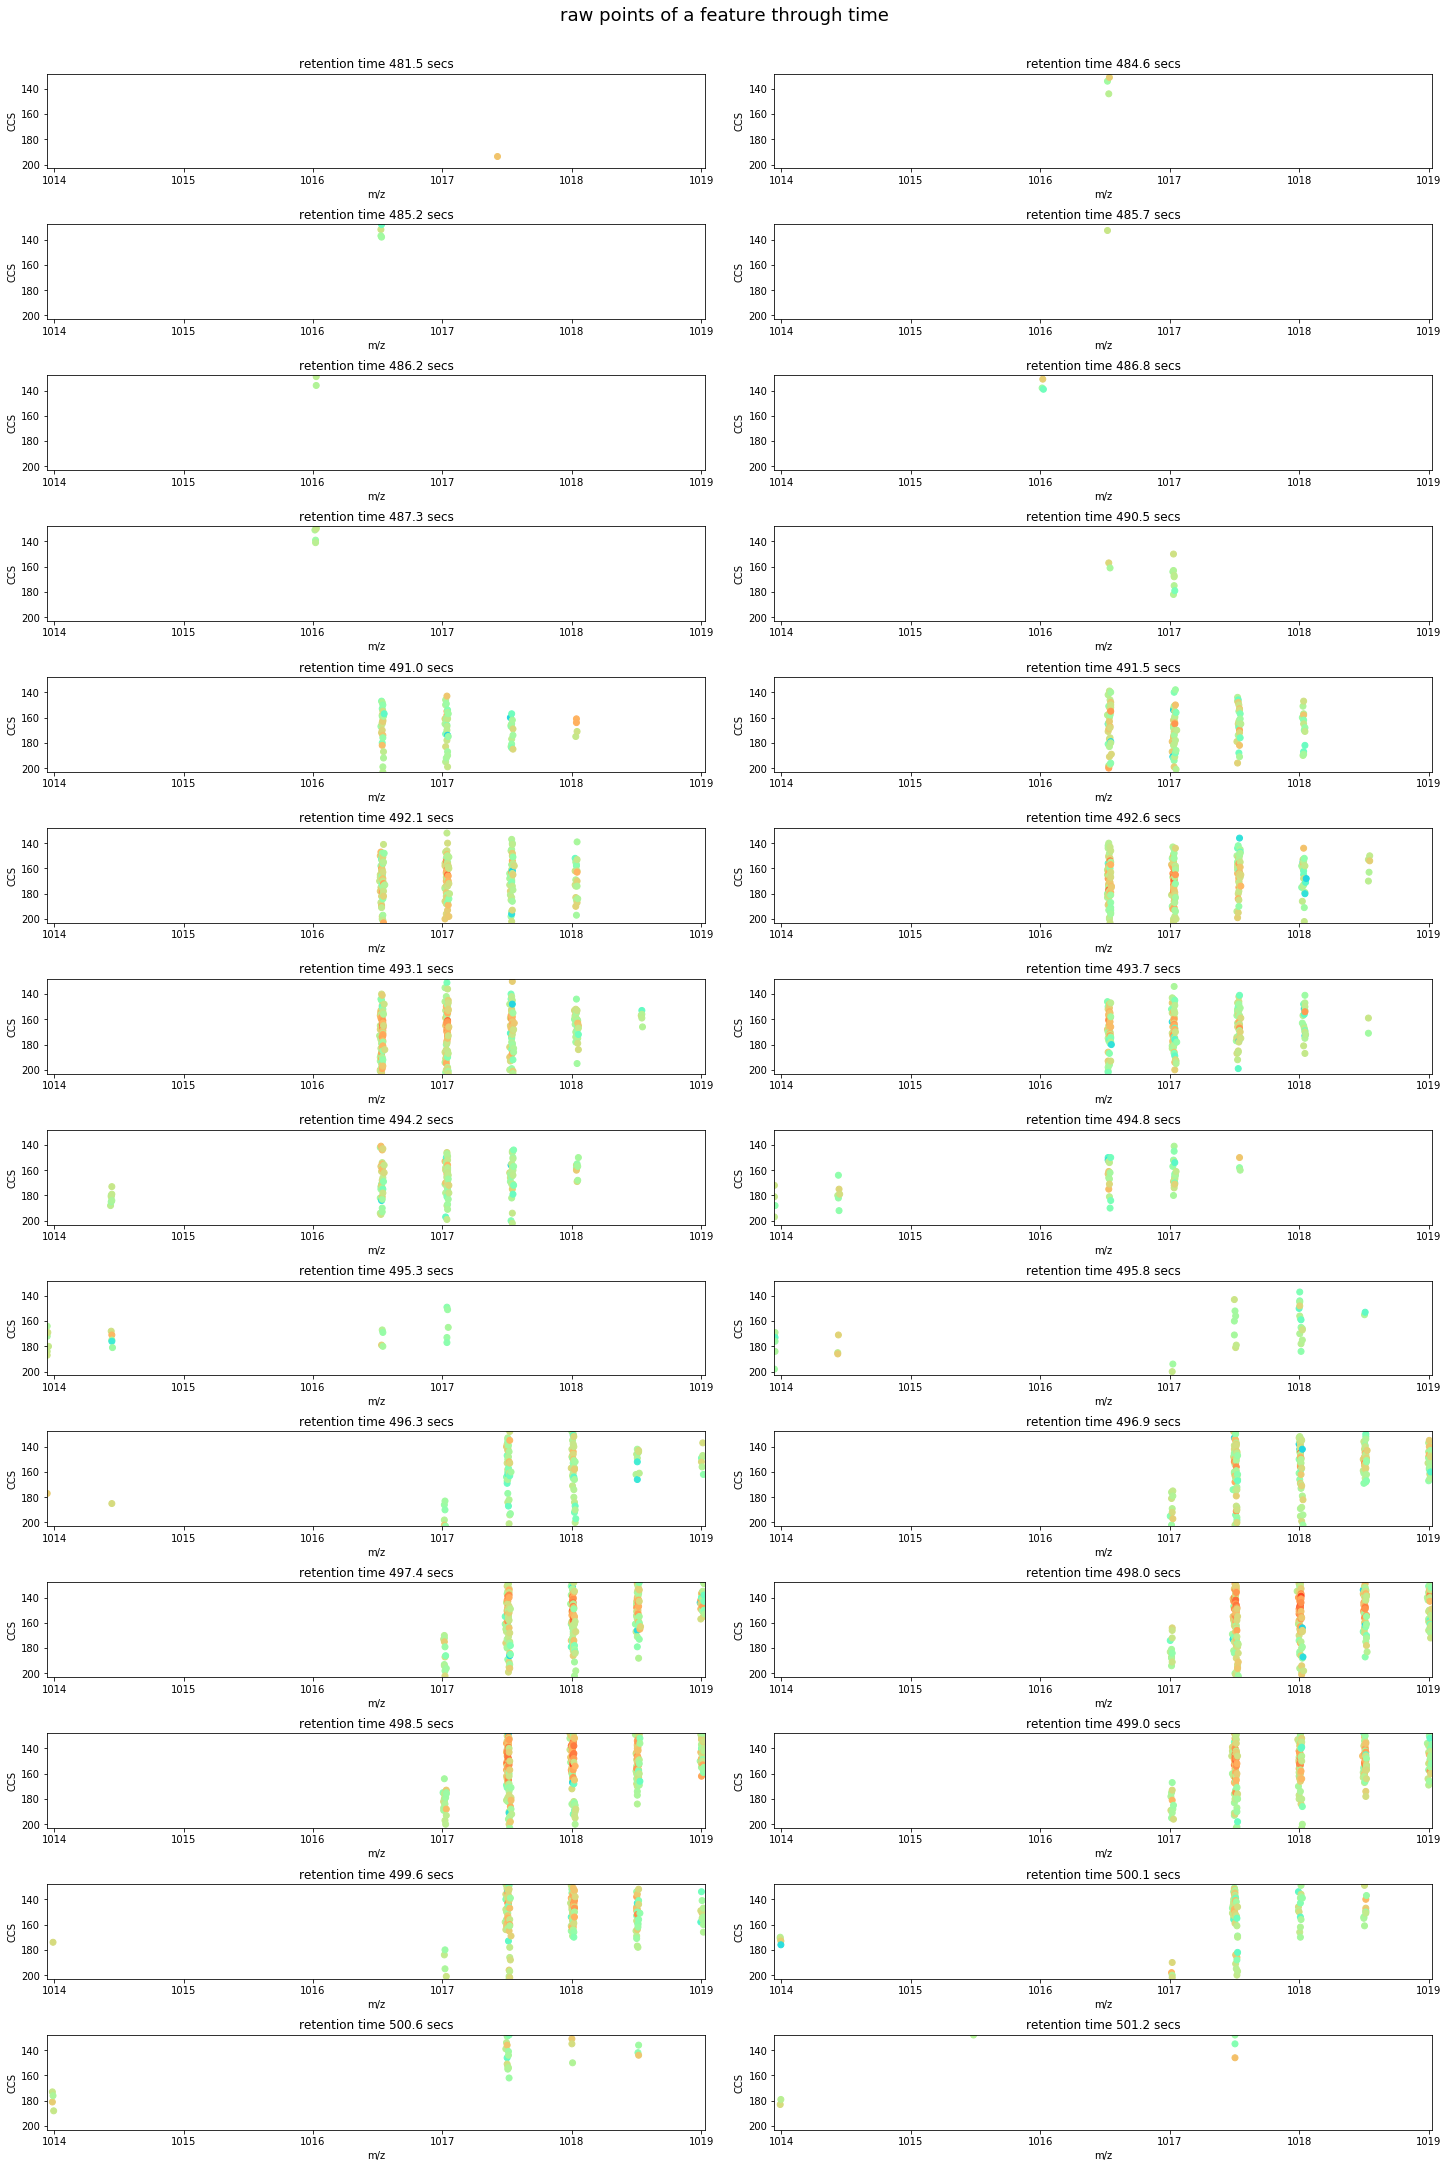

In [34]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(30)
f.set_figwidth(20)
f.suptitle('raw points of a precursor through time\n', fontsize=18)

# turn off the axes if the last row is incomplete
if len(frames_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,frame_df in enumerate(frames_l):
    r = int(row_idx / 2)
    c = row_idx % 2
    ax = axarr[r,c]  # row, column

    retention_time = frame_df.iloc[0].retention_time_secs
    ax.set_title('retention time {} secs'.format(round(retention_time,1)))

    ax.scatter(frame_df.mz, frame_df.scan, c=frame_df.colour)

    # set up axes
    ax.set_xlim((mz_lower,mz_upper))
    ax.set_ylim((scan_upper,scan_lower))
    ax.set_xlabel('m/z')
    ax.set_ylabel('CCS')

plt.show()